In [39]:
# import numpy as np
# import matplotlib.pyplot as plt
# import pandas as pd

# A, B = 2.45, 0.003245
# mu, sigma = 0, 1.1 # mean and standard deviation
# def genData(time):
#     s = np.random.normal(mu, sigma, time)
#     ys = []
#     for i in range(0, time):
#         ys.append(A*np.exp(i*B) + s[i])
#     return ys

# xs = range(0, 1000)
# ys = genData(1000)

# df = pd.DataFrame(data={"X":xs, "Y":ys})

# plt.plot(xs, ys)

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
import time
from scipy import interpolate

---
### Helper Functions

In [2]:
def getSeriesDF(cid, filename):
    localDF = pd.read_csv('data/Chunks/'+fileName+".csv").drop(columns=['Unnamed: 0'])
    localDF = localDF.loc[localDF['ContestId']==cid]
    localDF = localDF.assign(InvertedTime = localDF['SecondsRemaining'].max()-localDF['SecondsRemaining'])
    localDF = localDF.assign(SummedEntries = localDF['Entries'][::-1].cumsum()[::-1])
    return localDF
def zipCols(col1, col2):
    combined = []
    col1 = list(col1)
    col2 = list(col2)
    for i in range(0, len(col1)):
        combined.append([(col1[i]), col2[i]])
    return combined[::-1]
def combineStatesAndObservations(time, observations, states):
    combined = [[0, 0]]*max(time)
    stateSum = 0
    for i in range(0, len(combined)):
        if(i in list(time)):
            index = list(time).index(i)

            stateSum = states.iloc[index]
            combined[i] = [observations.iloc[index], states.iloc[index]]
        else:
            combined[i] = [0, stateSum]
    return combined

chunkMapDF = pd.read_csv('data/chunkMap.csv')
def getRandomContestAndLocation():
    contest = chunkMapDF.sample(n=1).iloc[0]
    cid, fileName  = contest.ContestId, contest.Chunk
    return cid, fileName

def modelValues(A, B, Times, extended=False):
    y = []
    if(not extended):
        A = np.exp(A)
    for i in Times:
        if(i*B>709):
            val = 42
        else:        
            val = A*math.exp(B*i)
        y.append(val)
    return y

def get100Models(Xs, Times, extended=False):
    results = []
    dif = 1   
    if len(Xs)> 100:
        dif = int(len(Xs)/100.)             
    for i in range(0, len(Xs), dif):
        Xk = Xs[i].tolist()
        results.append(modelValues(Xk[0][0], Xk[1][0], Times, extended = extended))
    return results

def getKindaBigContest():
    cid, fileName = getRandomContestAndLocation()
#     print(cid, fileName)
    fullSeriesDF = getSeriesDF(cid, fileName)
    length = len(fullSeriesDF)
    if length < 10:
        return getKindaBigContest()
    else:
        return fullSeriesDF

def getQ(random_state):
    Q_sub = random_state.randn(2, 2)
    Q = np.dot(Q_sub, Q_sub.transpose())
    val = np.linalg.matrix_rank(Q)
    if(val == 2):
        return Q
    else:
        return getQ()

---
### Kalman Functions

In [6]:
def defaultParameters(df):
    random_state = np.random.RandomState(0)
    F = np.eye(2) #Transition Matrix (Identity Matrix)

    Z = list(df['Y']) #Observation matrix
    X0 = [[4.], [.0023]] #Inital parameters guess (?) <<<< NEED VALUES
    P0 = (np.eye(2) + random_state.randn(2, 2)*.1)*100*np.eye(2) #Covariance Matrix (The confidence in our prediction)
    R = random_state.rand()*5.05
#     Q = getQ(random_state)*1000
    Q = [[np.power(9.,62),0.],[0.,np.power(6.,65)]]
    w = np.random.multivariate_normal([0., 0.], Q)
    return {'random_state':random_state, 'F':F, 'Z':Z, 'X0':X0, 'P0':P0, 'R':R, 'Q':Q, 'w':w}

def plotSeries(df, offset=(0,0), title=""):
    df = df.assign(plotX=df['X']+offset[0]).assign(plotY=df['Y']+offset[1])

    fig = plt.figure()
    fig.set_size_inches([5, 2])
    ax = fig.add_subplot(111)
    
    ax.set_xlabel("Minutes Since Start")
    ax.set_xlim(xmin=0.0, xmax=df['plotX'].max()*1.1)

    ax.set_ylabel("Entries")
    ax.set_ylim(ymin=0.0, ymax=df['plotY'].max()*1.1)

    
    ax.plot(df['plotX'], df['plotY'])
    ax.set_title(title)

def setupSeries(df):
    localDF = df.copy(deep=True)
    localDF = localDF.assign(X=localDF["InvertedTime"]).assign(Y=localDF["SummedEntries"])
    localDF = localDF[['X', 'Y']].sort_values(by=['X'])
    return localDF

def seriesRelocate(df, newTime=-1):
    newLoc =(0, 0)
    df = df.assign(X=df['X']-newTime)
    df = df[df['X']>0]

    if(newTime>=0):
        newLoc = (newTime+df['X'].min(), df['Y'].min())
    df = df.assign(X=df['X']-df['X'].min())
    df = df.assign(Y=df['Y']-df['Y'].min())
    return df, newLoc

def AeBx(A, B, times, offset=(0,0)):
    y = []
    for i in times:
        if(i*B>709):
            val = -1
        else:        
            val = A*math.exp(B*i)
        y.append(val)
    return y

In [7]:
#NOTE! This is the predicted number of entrants based on the current timesetp
def kalmanPredictNextVal(tCurr, xCurr,parameters, extended=False):
    if(extended):
        part1 = np.exp(xCurr[1][0]*tCurr)
        Hk = [part1, part1*(xCurr[0][0]*tCurr)]
        Zk = xCurr[0][0]*np.exp(xCurr[1][0]*tCurr)
        return Hk,  Zk
    else:
        Hk = [1., tCurr]
        Zk = np.dot(Hk, xCurr) + np.random.normal(loc=0., scale=parameters['R']) #<----- Consider putting Vk instead of R
        return Hk,  Zk

In [8]:
def kalmanFilter(series, parameters, extended=False):
    Xs = []
    
    Pk = parameters['P0'] 
    Xk = parameters['X0'] 
    for n in range(0, len(series)):
        actual = np.array(series.iloc[n]['Y']) #Current actual
        time = np.array(series.iloc[n]['X']) #Current time
        Pk = Pk + parameters["Q"]

        Hk, Zk = kalmanPredictNextVal(time, Xk, parameters, extended=extended) 
        Yk = actual - Zk # residuals
        transposedH = [[Hk[0]],[Hk[1]]]
        Sk = np.dot(np.dot(Hk, Pk), transposedH)[0]+parameters['R']
        Kk = np.dot(Pk, transposedH)*(1/Sk)
        Xnext = Xk + Kk*Yk        
        p_part = (np.eye(2)-np.outer(Kk, Hk))
        Pnext = np.dot(p_part, Pk)
        
        Xs.append([Xk[0][0], Xk[1][0]])
        #Set new vars based on current observation
        Pk = Pnext
        Xk = Xnext
    return Xs

In [45]:
defaultParameters(bDF)['R']

2.1394567366614687

---
### Testing Q and R

In [41]:
#the weighter function takes in a x scaled 0 to 1 for how close to the final time
def qualityChecker(actualDF, testDF, weighter=lambda x: 1, absoluteVal=False):
    xscale = actualDF['X'].max()
    yscale = actualDF['Y'].max()
    difSum = 0
    for x in range(0, len(actualDF)):
        rVal = actualDF.iloc[x]['Y']
        tVal = testDF.iloc[x]['Y']
        thisVal = ((tVal-rVal)/yscale * weighter(actualDF.iloc[x]['X']/xscale))
        if(absoluteVal):
            thisVal=abs(thisVal)
        difSum += thisVal
    return difSum
# qualityChecker(cDF, rDF)

THIS ONE!

In [54]:
cid, fileName = (51551348, 'chunk39')
aDF = getSeriesDF(cid, fileName)

results = []
# Rs = []

bDF = setupSeries(aDF)
cDF, offset = seriesRelocate(bDF, newTime=0)
p = defaultParameters(cDF)

for q2 in range(1, 10):
    for q1 in range(q2, 10):
        for r in range(0, 10):
            Q = [[np.power(10.,q1), 0.], [0, np.power(10.,q2)]]
            p['Q'] = Q
            p['R'] = np.power(2., r)

            paramList = kalmanFilter(cDF, p, extended=True)
            paramFinal = paramList[-1:][0]

            rDF = cDF.assign(Y=AeBx(paramFinal[0], paramFinal[1], cDF['X'], offset=offset))
            R1 = qualityChecker(cDF, rDF, weighter=lambda x: 1)
            R2 = qualityChecker(cDF, rDF, weighter=lambda x: 1, absoluteVal=True)
            R3 = qualityChecker(cDF, rDF, weighter=lambda x: x)
            R4 = qualityChecker(cDF, rDF, weighter=lambda x: x, absoluteVal=True)
            R5 = qualityChecker(cDF, rDF, weighter=lambda x: np.power(x,2))
            R6 = qualityChecker(cDF, rDF, weighter=lambda x: np.power(x,2), absoluteVal=True)

    #         print("(i^"+str(q1)+", i^"+str(q2)+") --> " +str(R))
            newObj = {"contestId":cid, "Q1":q1, "Q2":q2, "R":p['R'], 
                      "flatWeight":R1, "flatWeight_abs":R2, 
                      "linearWeight":R3, "linearWeight_abs":R4,
                      "squareWeight":R5, "squareWeight_abs":R6}
    #         Qs.append(Q)
#             print(newObj)
            results.append(newObj)
    
theData = pd.DataFrame(data=results)
theData.to_csv("data/QR_Tests/"+str(cid)+"_results.csv")

KeyboardInterrupt: 

---

In [27]:
p = defaultParameters(cDF)
Q = [[np.power(10.,1), 0.], [0, np.power(10.,1)]]
p['Q'] = Q
paramList = kalmanFilter(cDF, p, extended=True)
paramFinal = paramList[-1:][0]
rDF = cDF.assign(Y=AeBx(paramFinal[0], paramFinal[1], cDF['X'], offset=offset))

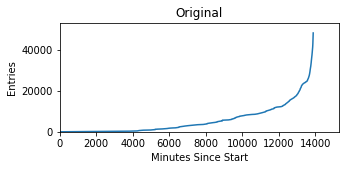

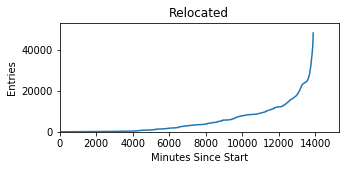

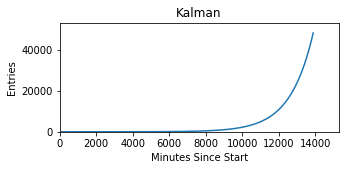

In [28]:
plotSeries(bDF, title='Original')
plotSeries(cDF, offset=offset, title='Relocated')
plotSeries(rDF, offset=offset, title='Kalman')

In [ ]:
# plotSeries(aDF, title='Original')
# # plotSeries(cDF, offset=offset, title='Relocated')
# # plotSeries(rDF, offset=offset, title='Kalman')

In [17]:
min(Rs)

19541581.62100805

In [302]:
savedRs = {'weightx=1': saveR, 'weightx=y':Rs}

[1.001889341551672, 0.000783181826766549]


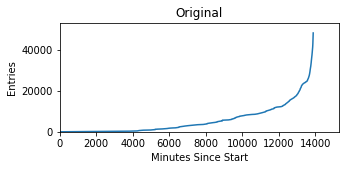

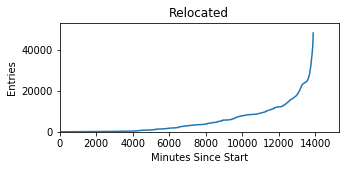

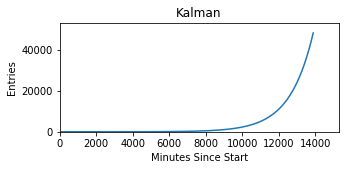

In [275]:
bDF = setupSeries(aDF)
cDF, offset = seriesRelocate(bDF, newTime=100)

p = defaultParameters(cDF)
p['Q'] = [[9,0.],[0.,1]]

paramList = kalmanFilter(cDF, p, extended=True)
paramFinal = paramList[-1:][0]
print(paramFinal)

rDF = cDF.assign(Y=AeBx(paramFinal[0], paramFinal[1], cDF['X'], offset=offset))


plotSeries(bDF, title='Original')
plotSeries(cDF, offset=offset, title='Relocated')
plotSeries(rDF, offset=offset, title='Kalman')


---
### Testing

[1.001889341551672, 0.000783181826766549]


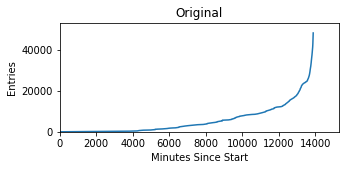

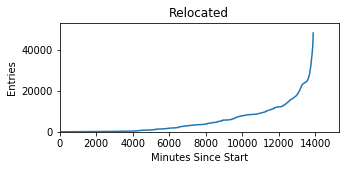

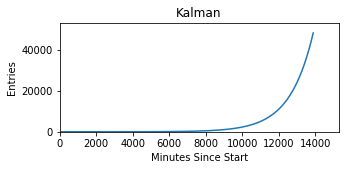

In [241]:
bDF = setupSeries(aDF)
cDF, offset = seriesRelocate(bDF, newTime=100)

p = defaultParameters(cDF)
p['Q'] = [[9,0.],[0.,1]]

paramList = kalmanFilter(cDF, p, extended=True)
paramFinal = paramList[-1:][0]
print(paramFinal)

rDF = cDF.assign(Y=AeBx(paramFinal[0], paramFinal[1], cDF['X'], offset=offset))


plotSeries(bDF, title='Original')
plotSeries(cDF, offset=offset, title='Relocated')
plotSeries(rDF, offset=offset, title='Kalman')


In [5]:
chunkMap = pd.read_csv("data/ChunkMap.csv")
def getChunkById(id):
    return chunkMap.loc[chunkMap['ContestId']==id].Chunk
getChunkById(51551348)

382357    chunk39
Name: Chunk, dtype: object

---
### Test!

In [5]:
def tableize(data, label, width = -1):
    widthStr = ""
    if(widthStr != -1):
        widthStr = "width:"+str(width)
    starter = "<table style='display: inline-block; margin:5px; border:thin solid black;'>"
    height = len(data)
    width = len(data[0])
    header = "<tr><th colspan="+str(width)+" style='text-align:center'>"+label+"</th></tr>"
    rows = ""
    for y in range(0, height):
        rows+="<tr >"
        for x in range(0, width):
            rows+="<td>" + str(data[y][x])+"</td>"
        rows+="</tr>"
#     print(data[-1:])
    ender = "</table>"
    return starter+header+rows+ender
# display(HTML(tableize([resultDict['Zs'][-1:]], 'Zs')))
def getResultStats(resultDict):
    Z0str = tableize([resultDict['Zs'][:1]], 'Z0', width="150px")
    Zfstr = tableize([resultDict['Zs'][-1:]], 'Zf', width="150px")

    Y0str = tableize([resultDict['Ys'][:1]], 'Y0')
    Yfstr = tableize([resultDict['Ys'][-1:]], 'Yf')

    H0str = tableize(resultDict['Hs'][-1:], 'H0')
    Hfstr = tableize(resultDict['Hs'][:1], 'Hf')

    S0str = tableize([resultDict['Ss'][-1:]], 'S0')
    Sfstr = tableize([resultDict['Ss'][:1]], 'Sf')

    P0str = tableize(resultDict['Ps'][:1][0], 'P0')
    Pfstr = tableize(resultDict['Ps'][-1:][0], 'Pf')

    K0str = tableize(resultDict['Ks'][:1][0], 'K0')
    Kfstr = tableize(resultDict['Ks'][-1:][0], 'Kf')

    X0str = tableize(resultDict['Xs'][:1][0], 'X0')
    Xfstr = tableize(resultDict['Xs'][-1:][0], 'Xf')
    return ((HTML(K0str+ X0str +P0str+  Z0str)), (HTML(Kfstr+ Xfstr +Pfstr+  Zfstr)))


A, B 4.734453304436821 0.00040904373929826344


A, B 91.82492358815603 0.00041212785188980743


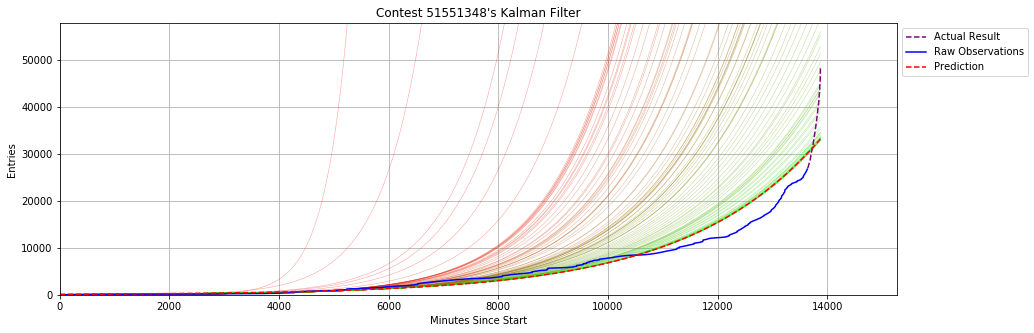

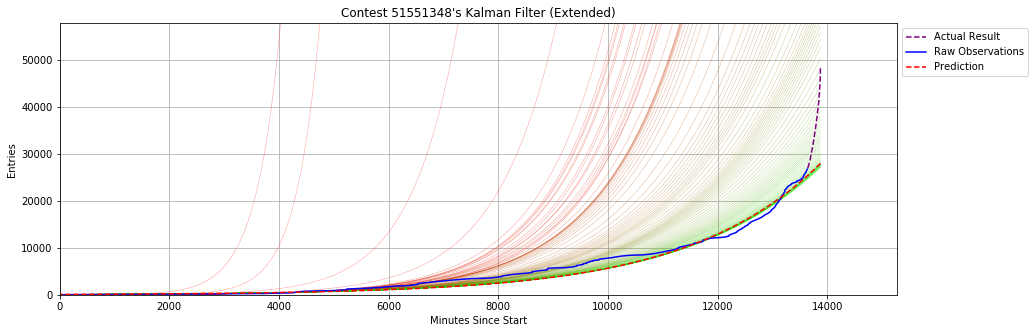

In [8]:
### THis is the super shitty one
cid, fileName = (51551348, 'chunk39')
aDF = getSeriesDF(cid, fileName)
KalmanFull(aDF, extended=False)
KalmanFull(aDF, extended=True)

---
## Where to actually start the filter

In [65]:
def getMovingAverage(aSeriesDF, targetCol, slopeLength = 10): #Way faster
    localSeries = aSeriesDF.copy(deep=True).reset_index()
    movingAverage = []
    localSum = 0
    numPoints = 0
    for index in list(range(0, len(localSeries)))[::-1]:
        localSum += localSeries.iloc[index][targetCol]
        numPoints += 1
        if(numPoints > slopeLength*1.5):
            localSum -= localSeries.iloc[index+slopeLength][targetCol]
            numPoints -= 1
            movingAverage.append(localSum/slopeLength)
        else:
            movingAverage.append("NONE")
    return movingAverage[::-1]
def SlopeStartIndex(slopes):
    thatIndex = getLastValidIndex(slopes)
    minSlope = slopes[thatIndex]
    for i in range(0, thatIndex)[::-1]:
        thisSlope = slopes[i]
        if(thisSlope > minSlope*1.425):
            break
        elif(thisSlope < minSlope):
            minSlope = thisSlope
            thatIndex = i
    return i
def getLastValidIndex(aList):
    for i in range(0, len(aList))[::-1]:
        if(aList[i] != "NONE"):
            return i

def getStartTime1(seriesDF, slopeLength=10, timeit = False, thisStr=""):
    if(timeit):
        t = time.time()
    slopes = getMovingAverage(seriesDF, 'Entries', slopeLength = slopeLength)
    vIndex = SlopeStartIndex(slopes)
    if(timeit):
        elapsed = time.time() - t
        print(thisStr, "Calculating new time took", round(elapsed, 4), "seconds" )
    return vIndex

In [66]:
def getLastLull(x, y, s = 10000000):
    tck = interpolate.splrep(x, y, s=s)
    xnew = np.arange(0, max(x), 1)
    dynew = interpolate.splev(xnew, tck, der=1)
    ynew = interpolate.splev(xnew, tck, der=0)
    mindy = dynew[-1:][0]
    for dy in dynew[::-1]:
        if(dy <= mindy):
            mindy = dy
        else:
            rIndex = list(dynew[::-1]).index(dy)
            return xnew[::-1][rIndex]
    return 0

def getStartTime2(seriesDF, slopeLength=10, timeit = False, thisStr = ""):
    if(timeit):
        t = time.time()
    vIndex = getLastLull(seriesDF['InvertedTime'], seriesDF['SummedEntries'])
    if(timeit):
        elapsed = time.time() - t
        print(thisStr, "Calculating new time took", round(elapsed, 4), "seconds" )
    return vIndex

In [67]:
cid, fileName = (20025622, 'chunk9')
aSeriesDF = getSeriesDF(cid, fileName)[::-1]
val1 = getStartTime1(aSeriesDF, timeit=True)
val2 = getStartTime2(aSeriesDF, timeit=True)
print(val1, val2)

 Calculating new time took 0.2067 seconds
 Calculating new time took 0.0014 seconds
365 645


---
### Mapping New Starts

In [81]:
def testNewStarts(aSeriesDF):
    val1 = getStartTime1(aSeriesDF, timeit=True, thisStr="Dumb way:")
    val2 = getStartTime2(aSeriesDF, timeit=True, thisStr="Smart way:")
    fig = plt.figure()
    fig.set_size_inches([8, 3])
    ax = fig.add_subplot(111)
#     graphLines(ax, aSeriesDF['InvertedTime'].tolist(), lines)
    seriesLine = ax.plot(aSeriesDF['InvertedTime'], aSeriesDF['SummedEntries'], c = 'black', label="Series Data")
    dumbLine = ax.axvline(x=val1, c="red", ls=":", label="Dumb way")
    interpLine = ax.axvline(x=val2, c="blue", ls=":", label="Smart Way")
    ax.legend(handles=[dumbLine, interpLine], bbox_to_anchor=(1, 1))
    ax.set_xlabel("Time (Minutes)")
    ax.set_ylabel("Entries")
    ax.set_title("Contest "+str(aSeriesDF.iloc[0]['ContestId']))

Dumb way: Calculating new time took 0.2047 seconds
Smart way: Calculating new time took 0.0011 seconds


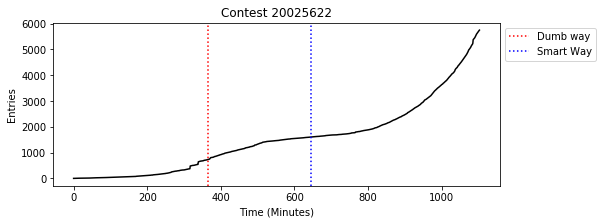

In [82]:
cid, fileName = (20025622, 'chunk9')
aSeriesDF = getSeriesDF(cid, fileName)[::-1]
testNewStarts(aSeriesDF)

Dumb way: Calculating new time took 0.1919 seconds
Smart way: Calculating new time took 0.0007 seconds


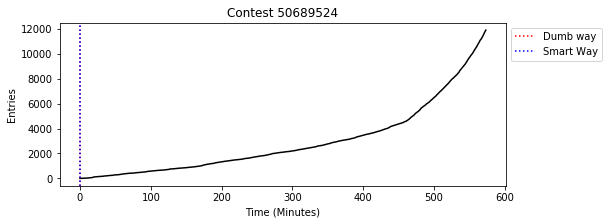

In [84]:
cid, fileName = (50689524, 'chunk38')
aDF = getSeriesDF(cid, fileName)[::-1]
testNewStarts(aDF)

Dumb way: Calculating new time took 0.6759 seconds
Smart way: Calculating new time took 0.0039 seconds


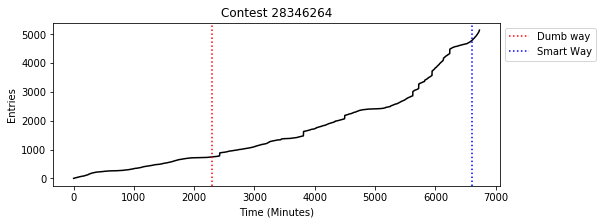

In [85]:
cid, fileName = (28346264, 'chunk47')
aDF = getSeriesDF(cid, fileName)[::-1]
testNewStarts(aDF)

Dumb way: Calculating new time took 0.5708 seconds
Smart way: Calculating new time took 0.0051 seconds


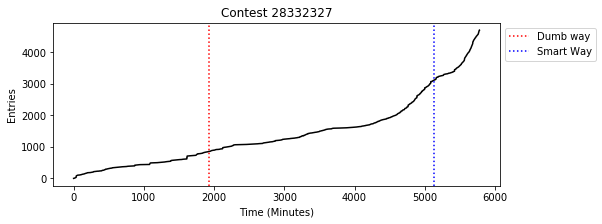

In [86]:
cid, fileName = (28332327, 'chunk47')
aDF = getSeriesDF(cid, fileName)[::-1]
testNewStarts(aDF)

Dumb way: Calculating new time took 0.19 seconds
Smart way: Calculating new time took 0.0022 seconds


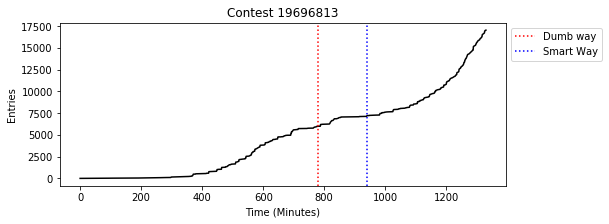

In [87]:
cid, fileName = (19696813, 'chunk8')
aDF = getSeriesDF(cid, fileName)[::-1]
testNewStarts(aDF)

Dumb way: Calculating new time took 0.2558 seconds
Smart way: Calculating new time took 0.0014 seconds


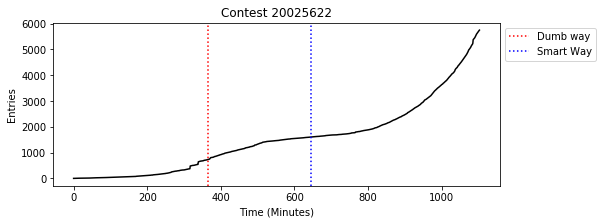

In [88]:
cid, fileName = (20025622, 'chunk9')
aDF = getSeriesDF(cid, fileName)[::-1]
testNewStarts(aDF)

Dumb way: Calculating new time took 0.4009 seconds
Smart way: Calculating new time took 0.0045 seconds


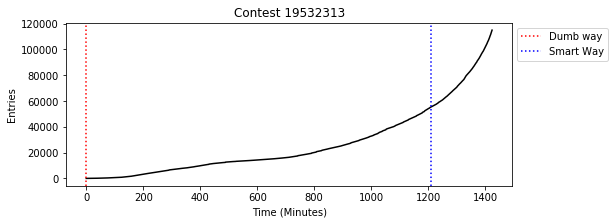

In [89]:
cid, fileName = (19532313, 'chunk8')
aDF = getSeriesDF(cid, fileName)[::-1]
testNewStarts(aDF)

---
### More testing

---
### More testing

In [178]:
cid, fileName = (20025622, 'chunk9')
aSeriesDF = getSeriesDF(cid, fileName)[::-1]
aSeriesDF = aSeriesDF.loc[aSeriesDF['SecondsRemaining']>240]
slopes = slopeWrapper(aSeriesDF, plot=False, slopeLength=40)

A, B 5.214632255003845 0.008407536397012772


A, B 97.94849146996658 0.010334350736720578


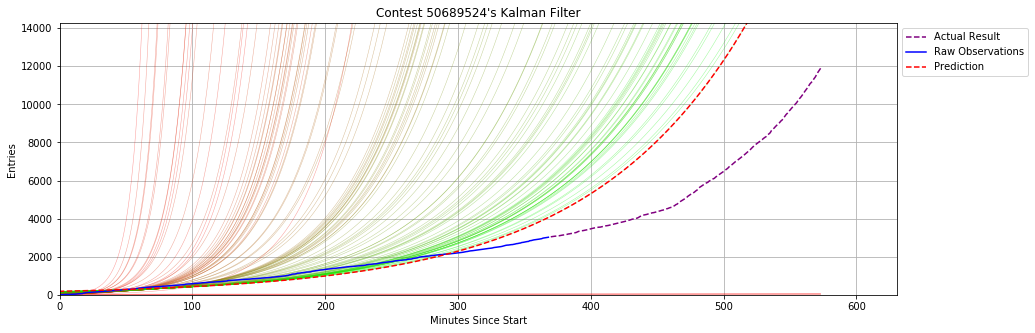

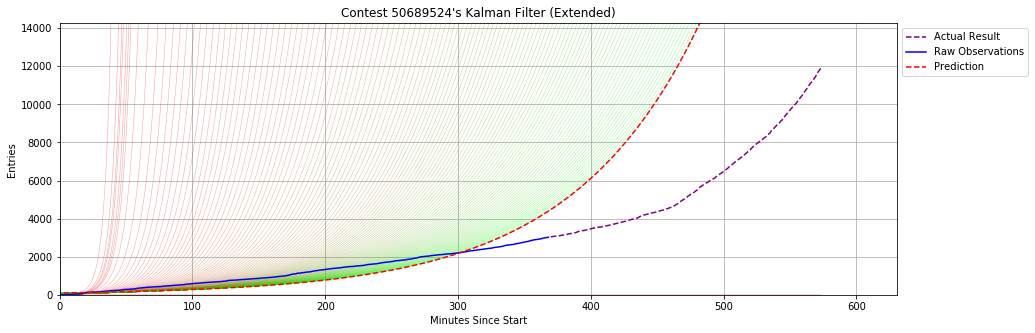

In [10]:
cid, fileName = (50689524, 'chunk38')
aDF = getSeriesDF(cid, fileName)
KalmanFull(aDF, extended=False)
KalmanFull(aDF, extended=True)

A, B 5.152082044395962 0.0005349995237056862


A, B 149.92485993972952 0.0005394119477195135


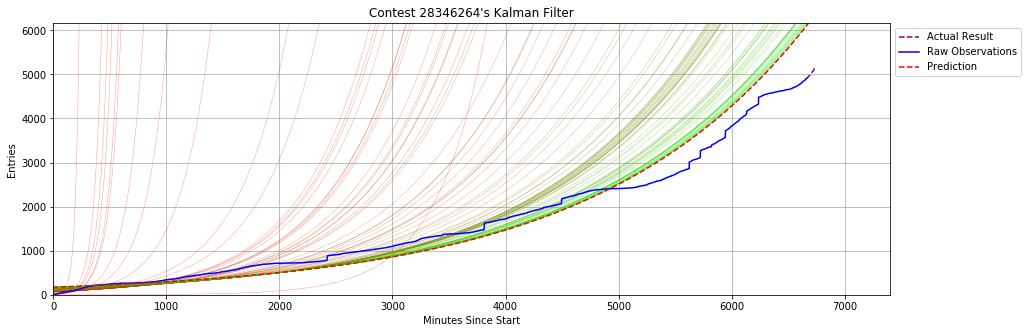

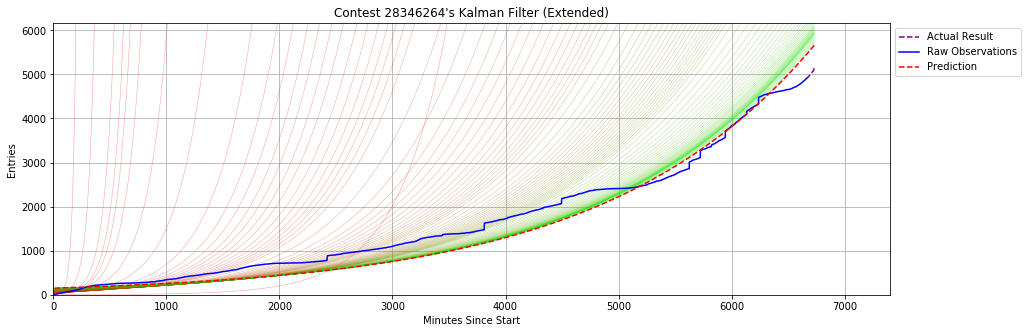

In [11]:
cid, fileName = (28346264, 'chunk47')
aDF = getSeriesDF(cid, fileName)
KalmanFull(aDF, extended=False)
KalmanFull(aDF, extended=True)

A, B 5.275112880430631 0.0005233529085119779


A, B 124.287491954882 0.0006314453061012468


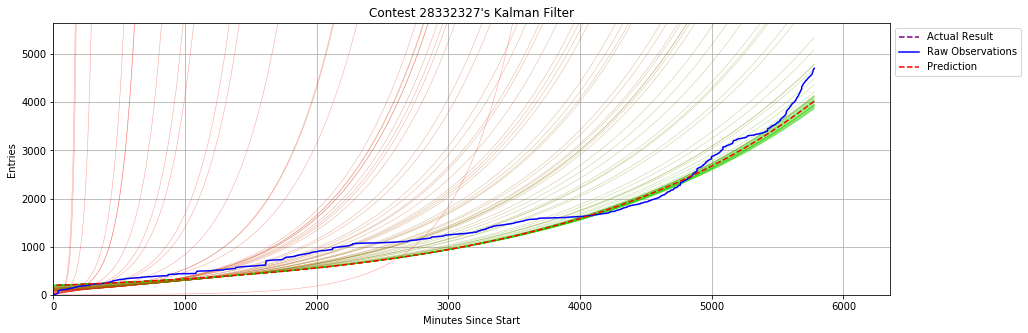

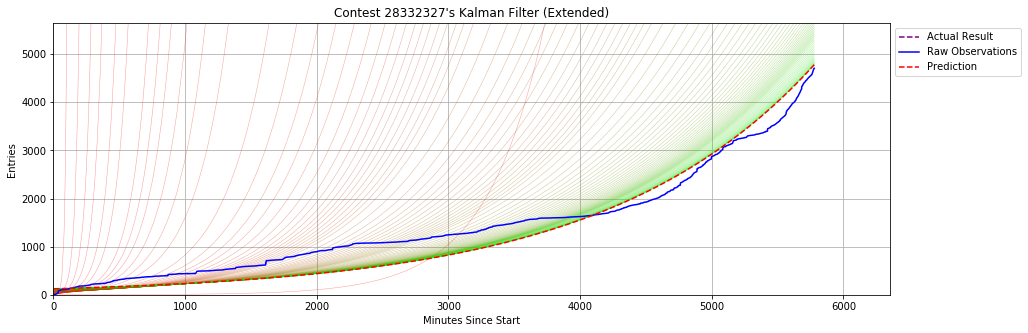

In [12]:
cid, fileName = (28332327, 'chunk47')
aDF = getSeriesDF(cid, fileName)
KalmanFull(aDF, extended=False)
KalmanFull(aDF, extended=True)

A, B 3.9693463034260446 0.005588184336074045


A, B 42.39392682684442 0.005247735205874491


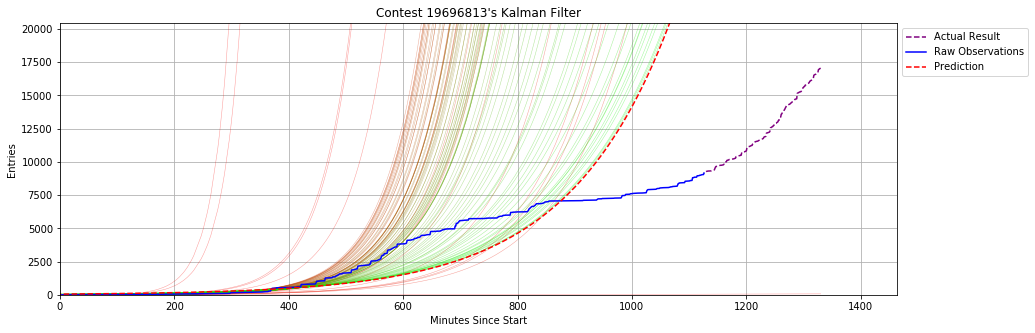

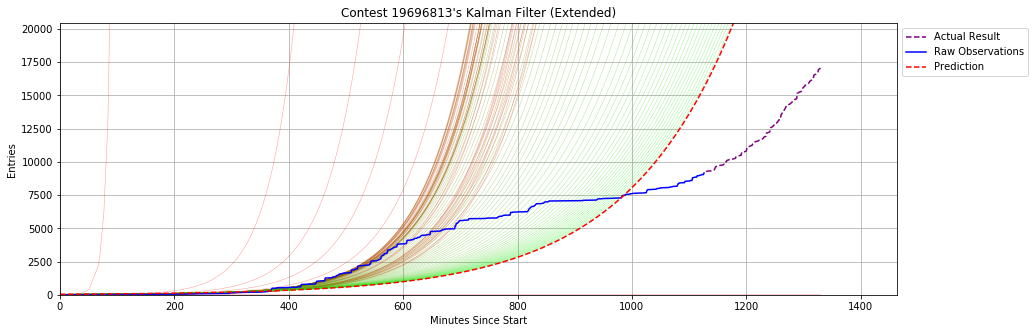

In [13]:
cid, fileName = (19696813, 'chunk8')
aDF = getSeriesDF(cid, fileName)
KalmanFull(aDF, extended=False)
KalmanFull(aDF, extended=True)

A, B 4.340533719434658 0.004419978335944529


A, B 48.79489171222114 0.00456349811356993


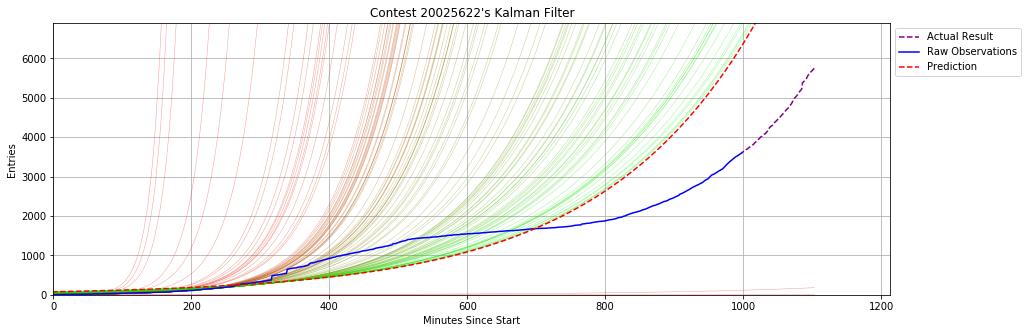

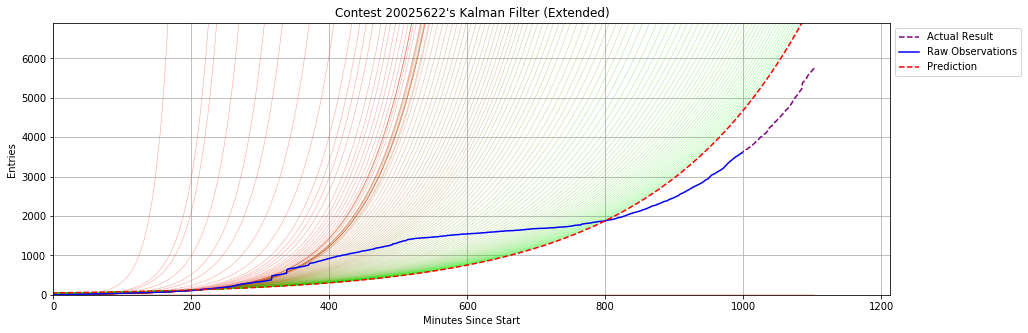

In [14]:
cid, fileName = (20025622, 'chunk9')
aDF = getSeriesDF(cid, fileName)
KalmanFull(aDF, extended=False)
KalmanFull(aDF, extended=True)

A, B 6.784278616090824 0.003827099549618339


A, B 411.0655889197999 0.004476211171361139


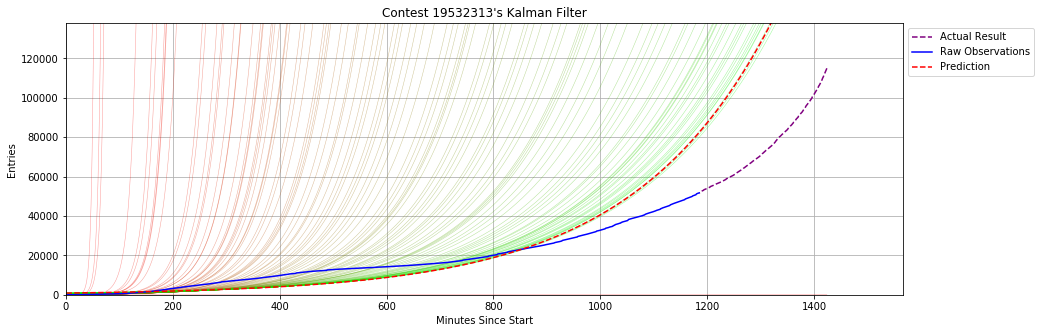

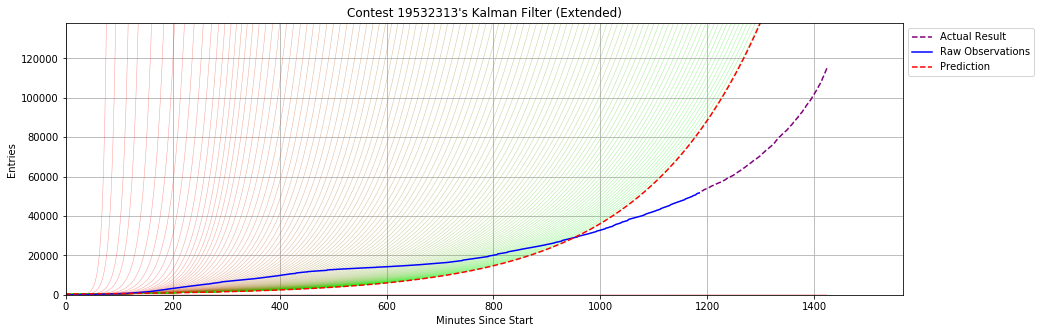

In [15]:
cid, fileName = (19532313, 'chunk8')
aDF = getSeriesDF(cid, fileName)
KalmanFull(aDF, extended=False)
KalmanFull(aDF, extended=True)

A, B 6.027319196080688 0.0038964884047997103


A, B 271.616328550637 0.004079536069589014


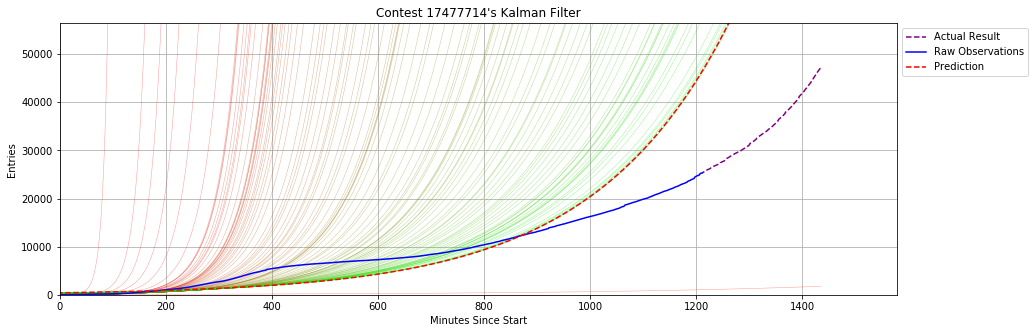

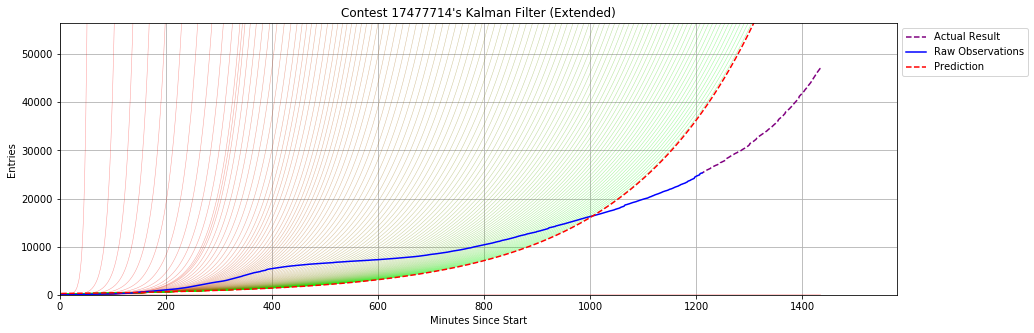

In [16]:
# cid, fileName = (52772327, 'chunk14')
cid, fileName = (17477714, 'chunk34')
aDF = getSeriesDF(cid, fileName)
KalmanFull(aDF, extended=False)
KalmanFull(aDF, extended=True)

A, B 2.2360575799122526 0.002146942496875773


A, B 6.955207840351869 0.002504236528050833


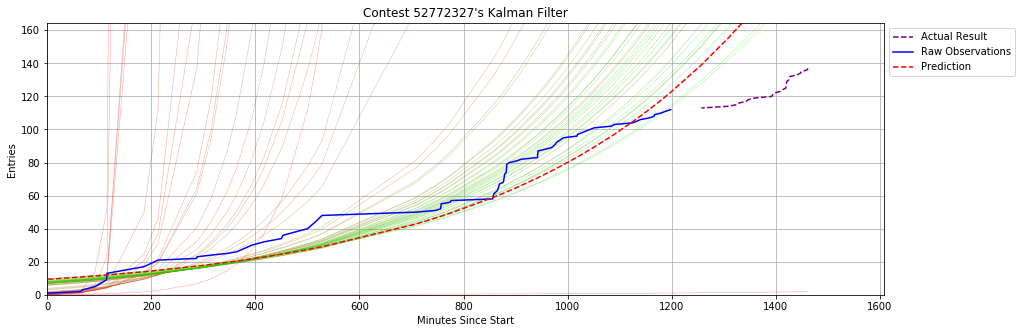

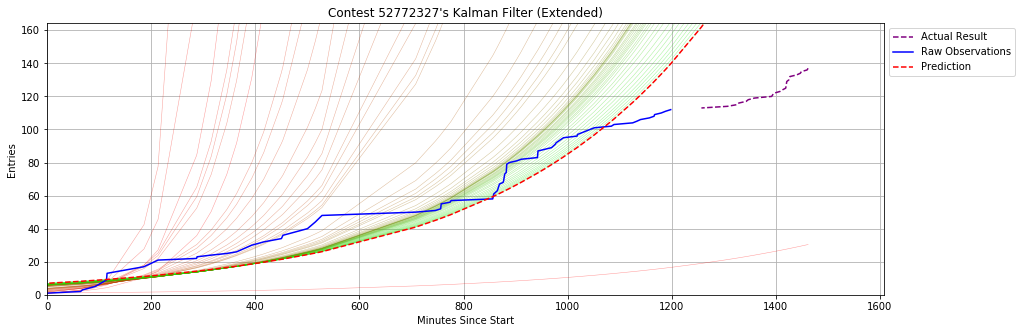

In [17]:
cid, fileName = (52772327, 'chunk14')
aDF = getSeriesDF(cid, fileName)
KalmanFull(aDF, extended=False)
KalmanFull(aDF, extended=True)

In [8]:
def modelSlopes(times, entries, slopes, slopeLength = 10):
    results = []
    for i in range(0, len(slopes)):
        thisSlope = slopes[i]
        thisTime = times[i]
        thisY = entries[i]
        thisLine = []
        if(thisSlope != "NONE"):
            for i in range(0, slopeLength+1, 1):
                thisLine.append(thisY + thisSlope*i*10)
        else:
            thisLine.append([])
        results.append(thisLine)
    return results

def graphLines(ax, times, lines, slopeLength = 10):
    for i in range(10, len(lines)):# lines[10:12]:
        if(lines[i] != [] and lines[i] != [[]]):
            line = lines[i]
            time = times[i]
            lTimes = list(range(time, time+slopeLength+1))
            ax.plot(lTimes, line,alpha=.9)


def slopeWrapper(seriesDF, plot=False, slopeLength = 10):
    slopes = getMovingAverage(seriesDF, 'Entries', slopeLength = slopeLength)
    if(plot):
        lines = modelSlopes(seriesDF['InvertedTime'].tolist(), seriesDF['SummedEntries'].tolist(), slopes)
        fig = plt.figure()
        fig.set_size_inches([15, 10])
        ax = fig.add_subplot(111)
        graphLines(ax, aSeriesDF['InvertedTime'].tolist(), lines)
        ax.plot(aSeriesDF['InvertedTime'].tolist(), aSeriesDF['SummedEntries'].tolist(), c = 'black')
        
        vIndex = SlopeStartIndex(slopes)
        ax.axvline(x=seriesDF['InvertedTime'].iloc[vIndex], c="black", ls=":")
    return slopes